# Import

In [1]:
# Клонируем репозитерий stylegan2-ada-pytorch
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/stylegan2-ada-pytorch

Cloning into '/content/stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 3.53 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
# Скачиваем модель StyleGAN2
!mkdir -p /content/StyleGAN2
!wget -q https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -O /content/StyleGAN2/ffhq.pkl # модель обученная на датасете ffhq(лица)

In [3]:
!pip install -q git+https://github.com/openai/CLIP.git # установка CLIP
!pip install -q ninja # утилита для сборки C++/CUDA кода
!pip install -q youtokentome # библиотека от Яндекса для работы с BPE-токенизатором

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
import sys
import os
sys.path.append('/content/stylegan2-ada-pytorch')
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'

import pickle
import copy

import numpy as np

import clip

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

from PIL import Image
import matplotlib.pyplot as plt

import re

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

RAND = 42

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [3]:
def cleaned_text(text) -> str:
    """
    Простая очистка текста
    """
    text = str(text) if text is not None else '' # преобразование text в строку, если это не строка
    text = text.lower()
    text = re.sub(r'[^а-яёa-z0-9\s.,*!?:-]', '', text)  # удаление лишних символов (кроме пунктуации)
    text = re.sub(r'\s+', ' ', text).strip()  # удаление лишних пробелов
    text = re.sub(r'^[^\w]+', '', text)  # удаление пунктуации в начале строки
    text = text.strip(' .')  # убирает лишние пробелы и точки в начале и в конце строки
    return text

In [4]:
def preprocessing_text(text: str,
                       device) -> torch.Tensor:
  """
  Делает простую очистку текста, токенизирует и возвращает эмбеддинги
  """
  model.eval()
  with torch.no_grad():
    text = cleaned_text(text)
    text_tokenize = clip.tokenize(text).to(device)
    text_features = model.encode_text(text_tokenize)

  return text_features.detach()

In [5]:
def preprocessing_image(image,
                        device) -> torch.Tensor:
    """
    Если torch.Tensor, то преобразует его в PIL, делает препроцессинг
    и возвращает эмбеддинги изображения
    """
    model.eval()
    if isinstance(image, torch.Tensor):
      # Для torch.Tensor из StyleGAN2 с диапазоном [-1,1]
      image = ((image + 1) / 2).clamp(0, 1) # [-1, 1] → [0, 1]
      image = (image * 255).to(torch.uint8) # конвертируем в диапазон [0, 255] и в тип uint8
      image = image.permute(0, 2, 3, 1).cpu().numpy() # меняем формат с CHW → HWC и преобразуем в np.array
      image = [Image.fromarray(img) for img in image] # cоздаём PIL.Image
      image_preproc = torch.stack([preprocess(img) for img in image]).to(device)
    else:
      # Для PIL-изображений
      image_preproc = preprocess(image).unsqueeze(0).to(device)

    image_features = model.encode_image(image_preproc)

    return image_features

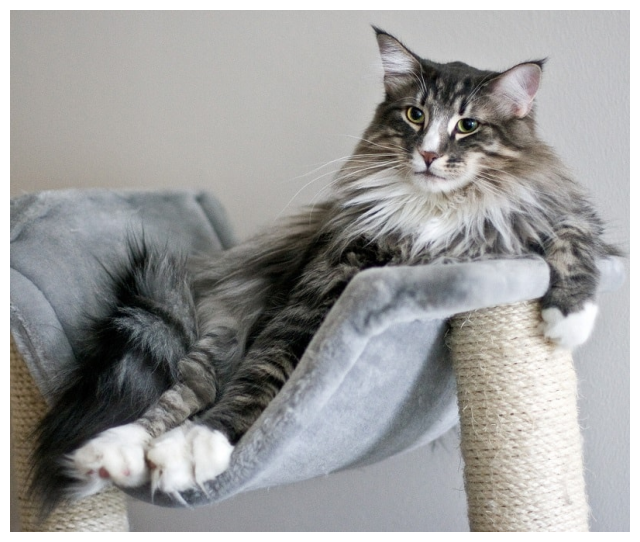

In [ ]:
# Загружаем свое фото
image =Image.open('/content/kot.jpg')

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')
plt.show()

# StyleGN2-ADA

In [6]:
with open('/content/StyleGAN2/ffhq.pkl', 'rb') as f:
  G = pickle.load(f)['G_ema'].to(device)

G_frozen = copy.deepcopy(G) # копия генератора (замороженный)

In [12]:
g = torch.Generator()
g.manual_seed(RAND)

z = torch.randn(4, G.z_dim, generator=g).to(device)
c = None
G.eval()
image_gan = G(z, c)

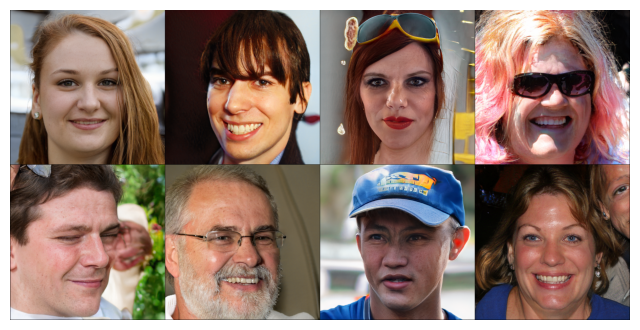

In [8]:
img = (image_gan.clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]
grid = make_grid(img, nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()

# CLIP

In [8]:
# Загружаем модель и процессор
model, preprocess = clip.load('ViT-B/32', device=device)

In [12]:
text_features = preprocessing_text('woman', device)

In [13]:
image_features = preprocessing_image(image_gan, device)

# Train

## Loss

In [9]:
def cosine_dist(text_features: torch.Tensor,
                image_features: torch.Tensor) -> torch.Tensor:
 """
 Считает глобальный CLIP-loss (cosine distance)

 :param text_features: вектора текста в пространстве CLIP
 :param image_features: вектора изображения в пространстве CLIP

 :return delta_text: косинусное расстояние
 """
 cosine_dist = 1 - F.cosine_similarity(text_features, image_features, dim=1)
 return cosine_dist.mean()

In [ ]:
def delta_text(model,
              preprocess,
              text_target: str,
              text_source: str) -> torch.Tensor:
  """
  Считает вектор текстового направления (между таргетом и текущим стилем)

  :param model: модель CLIP
  :param preprocess: препроцессор модели CLIP
  :param text_target: текст целевого стиля
  :param text_source: текст исходного стиля

  :return delta_text: вектор текстового направления
  """
  delta_text = preprocessing_text(text_target, device) - preprocessing_text(text_source, device)
  return delta_text

In [ ]:
def delta_image(model,
              preprocess,
              gen,
              gen_frozen) -> torch.Tensor:
  """
  Считает вектор визуального направления (между изображением до и после fine-tuning)

  :param model: модель CLIP
  :param preprocess: препроцессор модели CLIP
  :param gen: обучаемый генератор StyleGAN2
  :param gen_frozen: замороженный генератор StyleGAN2

  :return delta_image: вектор визуального направления
  """
  # Создает генератор случайных чисел и инициализирует его определённым значением
  g = torch.Generator()
  g.manual_seed(RAND)

  # Генерирует латентный вектор из нормального распределения
  z = torch.randn(4, gen.z_dim, generator=g).to(device)

  c = None # метки класса

  gen.eval()
  gen_frozen.eval()

  # Генерирует изображение
  image = gen(z, c)
  image_frozen = gen_frozen(z, c)

  delta_image = preprocessing_image(image, device) - preprocessing_image(image_frozen, device)
  return delta_image

In [ ]:
def clip_loss(delta_text: torch.Tensor,
              delta_image: torch.Tensor) -> torch.Tensor:
  """
  Ситает направленный CLIP-loss

  :param delta_text: вектор текстового направления
  :param delta_image: вектор визуального направления

  :return loss_clip: направленный CLIP-loss
  """
  loss_clip = 1 - F.cosine_similarity(delta_image, delta_text, dim=1)
  return loss_clip

## Train

In [10]:
def train_generator(generator,
                    generator_frozen,
                    model,
                    preprocess,
                    latent,
                    text,
                    epochs,
                    criterion,
                    device,
                    lr=0.0003,
                    scale=7,
                    c=None):
  """
  Обучает генератор StyleGAN2
  """
  loss_lst = []

  os.makedirs('results', exist_ok=True)

  optimizer = torch.optim.AdamW(generator.parameters(), lr=lr)

  generator.train()
  for param in generator.parameters():
    param.requires_grad = True

  for i in range(epochs):
    optimizer.zero_grad()

    image = generator(latent, c)

    text_features = preprocessing_text(text, device)
    image_features = preprocessing_image(image, device)

    loss = criterion(text_features, image_features) * scale
    loss.backward()
    optimizer.step()

    loss_lst.append(loss.item())

    torch.cuda.empty_cache()

    print(f'Эпоха {i + 1}: loss={loss.item():.4f}')

    if (i + 1) % 50 == 0:
      img = (image.clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]

      save_path = f'results/generated_image_epoch_{i+1}.png'
      save_image(img, save_path)

      grid = make_grid(img, nrow=4)
      plt.figure(figsize=(8, 8))
      plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
      plt.axis('off')
      plt.show()

  plt.figure(figsize=(8, 8))
  plt.plot(loss_lst)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('График лосса')
  plt.grid(True)
  plt.show()

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Эпоха 1: loss=5.4961
Эпоха 2: loss=5.4688
Эпоха 3: loss=5.4609
Эпоха 4: loss=5.4766
Эпоха 5: loss=5.4727
Эпоха 6: loss=5.4570
Эпоха 7: loss=5.4492
Эпоха 8: loss=5.4805
Эпоха 9: loss=5.4648
Эпоха 10: loss=5.4609
Эпоха 11: loss=5.4766
Эпоха 12: loss=5.4570
Эпоха 13: loss=5.4766
Эпоха 14: loss=5.4531
Эпоха 15: loss=5.4688
Эпоха 16: loss=5.4727
Эпоха 17: loss=5.4531
Эпоха 18: loss=5.4844
Эпоха 19: loss=5.4883
Эпоха 20: loss=5.4609
Эпоха 21: loss=5.4883
Эпоха 22: loss=5.4492
Эпоха 23: loss=5.4375
Эпоха 24: loss=5.4844
Эпоха 25: loss=5.4844
Эпоха 26: loss=5.4336
Эпоха 27: loss=5.4688
Эпоха 28: loss=5.4844
Эпоха 29: loss=5.4531
Эпоха 30: loss=5.4883
Эпоха 31: loss=5.4766
Эпоха 32: loss=5.4844
Эпоха 33: loss=5.4688
Эпоха 34: loss=5.4609
Эпоха 35: loss=5.4883
Эпоха 36: loss=5.4414
Эпоха 37: loss=5.4570
Эпоха 38: loss=5.4570
Эпоха 39: loss=5.4531
Эпоха 40: loss=5.4688
Эпоха 41: loss=5.4570


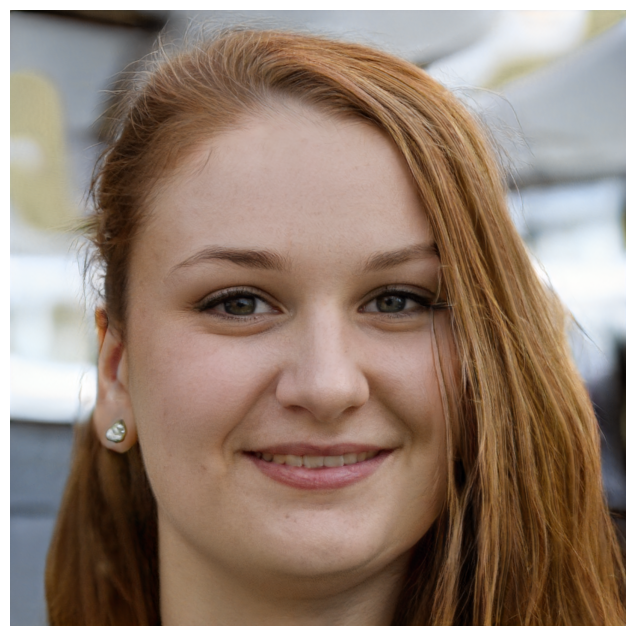

Эпоха 51: loss=5.4688
Эпоха 52: loss=5.4766
Эпоха 53: loss=5.4531
Эпоха 54: loss=5.4844
Эпоха 55: loss=5.4492
Эпоха 56: loss=5.4531
Эпоха 57: loss=5.4492
Эпоха 58: loss=5.4609
Эпоха 59: loss=5.4531
Эпоха 60: loss=5.4688
Эпоха 61: loss=5.4609
Эпоха 62: loss=5.4805
Эпоха 63: loss=5.4844
Эпоха 64: loss=5.4609
Эпоха 65: loss=5.4922
Эпоха 66: loss=5.4844
Эпоха 67: loss=5.4805
Эпоха 68: loss=5.4492
Эпоха 69: loss=5.4609
Эпоха 70: loss=5.4648
Эпоха 71: loss=5.4688
Эпоха 72: loss=5.4531
Эпоха 73: loss=5.4766
Эпоха 74: loss=5.4844
Эпоха 75: loss=5.4688
Эпоха 76: loss=5.4648
Эпоха 77: loss=5.4648
Эпоха 78: loss=5.4609
Эпоха 79: loss=5.4570
Эпоха 80: loss=5.4961
Эпоха 81: loss=5.4766
Эпоха 82: loss=5.4531
Эпоха 83: loss=5.4531
Эпоха 84: loss=5.4805
Эпоха 85: loss=5.4766
Эпоха 86: loss=5.4609
Эпоха 87: loss=5.4609
Эпоха 88: loss=5.4297
Эпоха 89: loss=5.4609
Эпоха 90: loss=5.4727
Эпоха 91: loss=5.4688
Эпоха 92: loss=5.4570
Эпоха 93: loss=5.4688
Эпоха 94: loss=5.4844
Эпоха 95: loss=5.4766
Эпоха 96: 

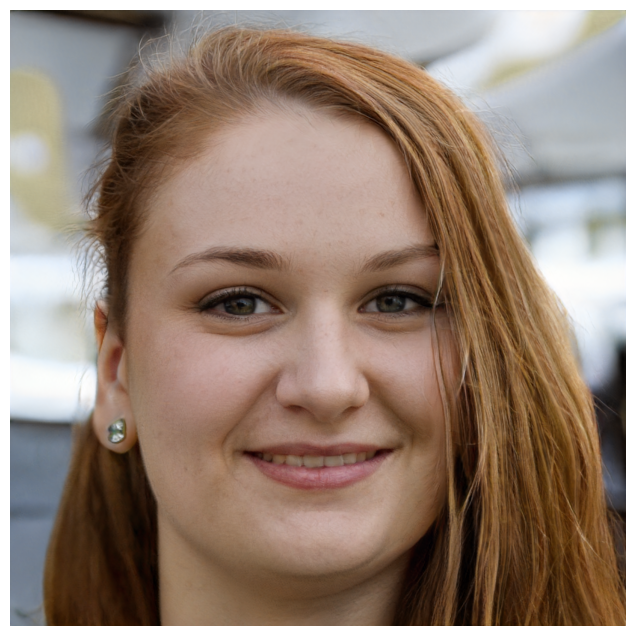

Эпоха 101: loss=5.4531
Эпоха 102: loss=5.4609
Эпоха 103: loss=5.4766
Эпоха 104: loss=5.4688
Эпоха 105: loss=5.4531
Эпоха 106: loss=5.4727
Эпоха 107: loss=5.4531
Эпоха 108: loss=5.4883
Эпоха 109: loss=5.4648
Эпоха 110: loss=5.4844
Эпоха 111: loss=5.4570
Эпоха 112: loss=5.4688
Эпоха 113: loss=5.4609
Эпоха 114: loss=5.4766
Эпоха 115: loss=5.4688
Эпоха 116: loss=5.4531
Эпоха 117: loss=5.4648
Эпоха 118: loss=5.4727
Эпоха 119: loss=5.4492
Эпоха 120: loss=5.4609
Эпоха 121: loss=5.4531
Эпоха 122: loss=5.4688
Эпоха 123: loss=5.4805
Эпоха 124: loss=5.4375
Эпоха 125: loss=5.4688
Эпоха 126: loss=5.4648
Эпоха 127: loss=5.4609
Эпоха 128: loss=5.4609
Эпоха 129: loss=5.4648
Эпоха 130: loss=5.4688
Эпоха 131: loss=5.4688
Эпоха 132: loss=5.4727
Эпоха 133: loss=5.4375
Эпоха 134: loss=5.4766
Эпоха 135: loss=5.4688
Эпоха 136: loss=5.4609
Эпоха 137: loss=5.4805
Эпоха 138: loss=5.4688
Эпоха 139: loss=5.4844
Эпоха 140: loss=5.4531
Эпоха 141: loss=5.4570
Эпоха 142: loss=5.4844
Эпоха 143: loss=5.4844
Эпоха 144: 

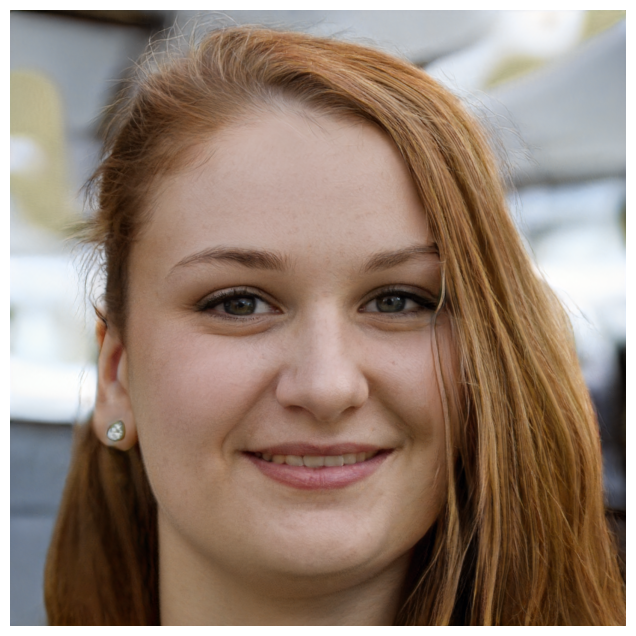

Эпоха 151: loss=5.4727
Эпоха 152: loss=5.4609
Эпоха 153: loss=5.4766
Эпоха 154: loss=5.4531
Эпоха 155: loss=5.4844
Эпоха 156: loss=5.4844
Эпоха 157: loss=5.4766
Эпоха 158: loss=5.4961
Эпоха 159: loss=5.4531
Эпоха 160: loss=5.4766
Эпоха 161: loss=5.5000
Эпоха 162: loss=5.4609
Эпоха 163: loss=5.4648
Эпоха 164: loss=5.4609
Эпоха 165: loss=5.4570
Эпоха 166: loss=5.4727
Эпоха 167: loss=5.4727
Эпоха 168: loss=5.4688
Эпоха 169: loss=5.4766
Эпоха 170: loss=5.4570
Эпоха 171: loss=5.4805
Эпоха 172: loss=5.4688
Эпоха 173: loss=5.4570
Эпоха 174: loss=5.4531
Эпоха 175: loss=5.4844
Эпоха 176: loss=5.4531
Эпоха 177: loss=5.4727
Эпоха 178: loss=5.4805
Эпоха 179: loss=5.4805
Эпоха 180: loss=5.4688
Эпоха 181: loss=5.4844
Эпоха 182: loss=5.4688
Эпоха 183: loss=5.4727
Эпоха 184: loss=5.4648
Эпоха 185: loss=5.4648
Эпоха 186: loss=5.4609
Эпоха 187: loss=5.4570
Эпоха 188: loss=5.4570
Эпоха 189: loss=5.4492
Эпоха 190: loss=5.4688
Эпоха 191: loss=5.4609
Эпоха 192: loss=5.4688
Эпоха 193: loss=5.4727
Эпоха 194: 

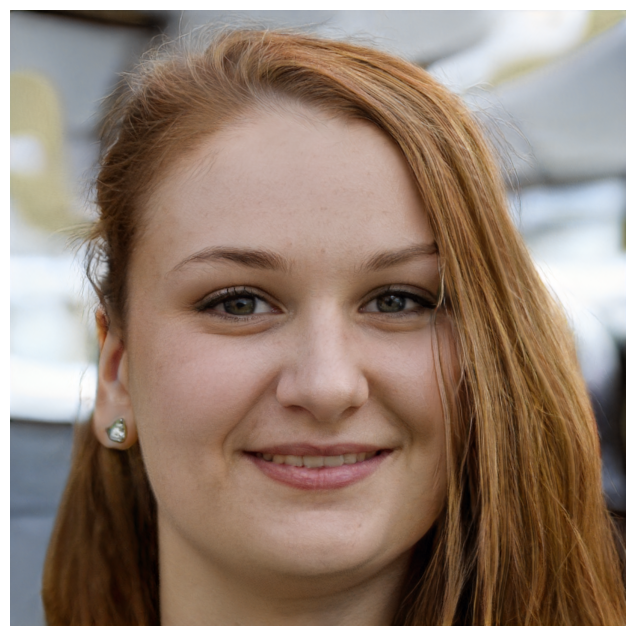

Эпоха 201: loss=5.4570
Эпоха 202: loss=5.4727
Эпоха 203: loss=5.4844
Эпоха 204: loss=5.4883
Эпоха 205: loss=5.4727
Эпоха 206: loss=5.4883
Эпоха 207: loss=5.4609
Эпоха 208: loss=5.4766
Эпоха 209: loss=5.4727
Эпоха 210: loss=5.4766
Эпоха 211: loss=5.4609
Эпоха 212: loss=5.4609
Эпоха 213: loss=5.4531
Эпоха 214: loss=5.4648
Эпоха 215: loss=5.4531
Эпоха 216: loss=5.4727
Эпоха 217: loss=5.4883
Эпоха 218: loss=5.4766
Эпоха 219: loss=5.4688
Эпоха 220: loss=5.4727
Эпоха 221: loss=5.4609
Эпоха 222: loss=5.4492
Эпоха 223: loss=5.4648
Эпоха 224: loss=5.4570
Эпоха 225: loss=5.4609
Эпоха 226: loss=5.4688
Эпоха 227: loss=5.4688
Эпоха 228: loss=5.4531
Эпоха 229: loss=5.4844
Эпоха 230: loss=5.4688
Эпоха 231: loss=5.4570
Эпоха 232: loss=5.4844
Эпоха 233: loss=5.4883
Эпоха 234: loss=5.4844
Эпоха 235: loss=5.4492
Эпоха 236: loss=5.4531
Эпоха 237: loss=5.4727
Эпоха 238: loss=5.4688
Эпоха 239: loss=5.4883
Эпоха 240: loss=5.4648
Эпоха 241: loss=5.4844
Эпоха 242: loss=5.4531
Эпоха 243: loss=5.4922
Эпоха 244: 

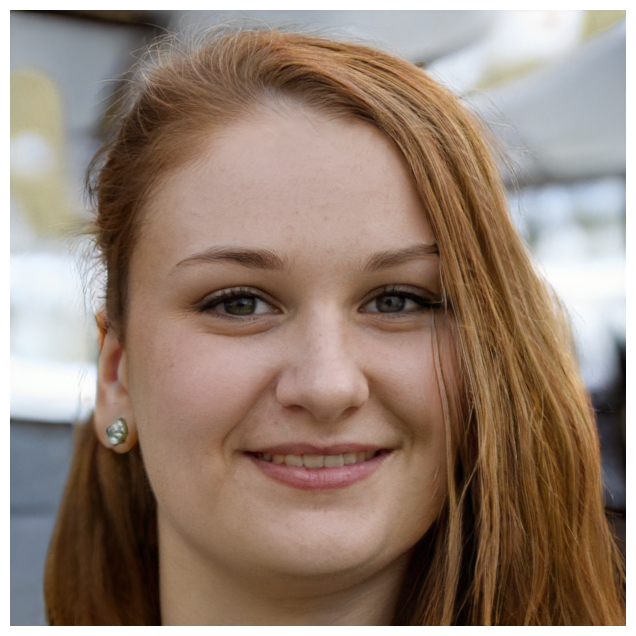

Эпоха 251: loss=5.4531
Эпоха 252: loss=5.4844
Эпоха 253: loss=5.4570
Эпоха 254: loss=5.4609
Эпоха 255: loss=5.4609
Эпоха 256: loss=5.4727
Эпоха 257: loss=5.4766
Эпоха 258: loss=5.4531
Эпоха 259: loss=5.4805
Эпоха 260: loss=5.4609
Эпоха 261: loss=5.4570
Эпоха 262: loss=5.4609
Эпоха 263: loss=5.4727
Эпоха 264: loss=5.4727
Эпоха 265: loss=5.4805
Эпоха 266: loss=5.4844
Эпоха 267: loss=5.4648
Эпоха 268: loss=5.4844
Эпоха 269: loss=5.4648
Эпоха 270: loss=5.4727
Эпоха 271: loss=5.4648
Эпоха 272: loss=5.4688
Эпоха 273: loss=5.4531
Эпоха 274: loss=5.4844
Эпоха 275: loss=5.4805
Эпоха 276: loss=5.4766
Эпоха 277: loss=5.4492
Эпоха 278: loss=5.4844
Эпоха 279: loss=5.4688
Эпоха 280: loss=5.4727
Эпоха 281: loss=5.4492
Эпоха 282: loss=5.4961
Эпоха 283: loss=5.4609
Эпоха 284: loss=5.4453
Эпоха 285: loss=5.4688
Эпоха 286: loss=5.4609
Эпоха 287: loss=5.4531
Эпоха 288: loss=5.4688
Эпоха 289: loss=5.4609
Эпоха 290: loss=5.4531
Эпоха 291: loss=5.4688
Эпоха 292: loss=5.4727
Эпоха 293: loss=5.4531
Эпоха 294: 

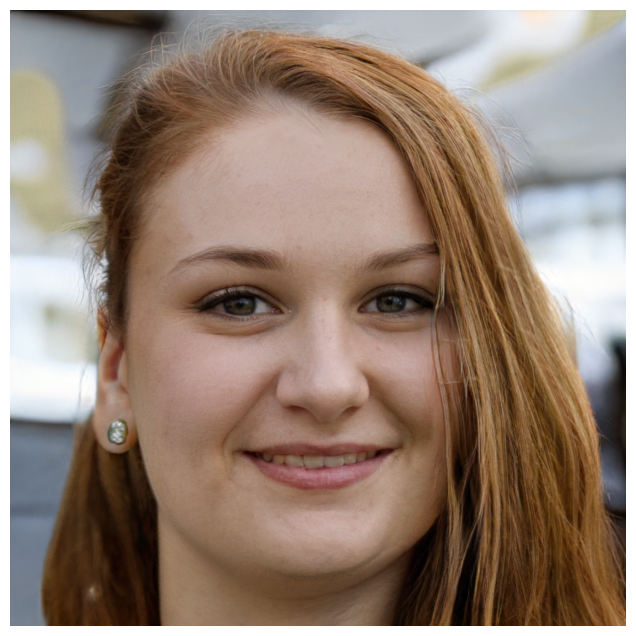

Эпоха 301: loss=5.4609


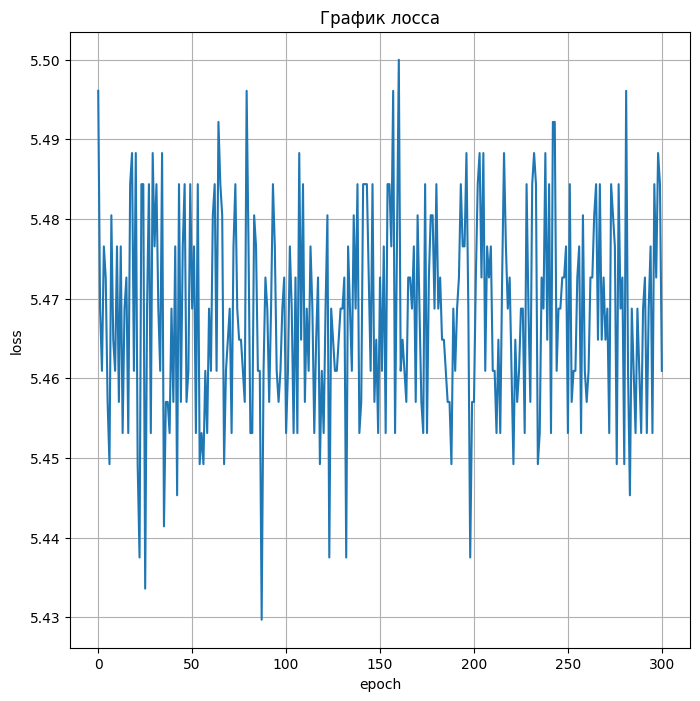

In [11]:
train_generator(generator=G,
                generator_frozen=G_frozen,
                model=model,
                preprocess=preprocess,
                latent=z,
                text='devil',
                epochs=301,
                criterion=cosine_dist,
                device=device)